# Notes

### Nasser Branch 
**October 10th :** 
Tokenization, Frequency of tokens $\rightarrow$ csv file 

**October 14th :**
Remove IDs column, Remove punctuation, Convert uppercase into lowercase, Remove special characters, 
Tokenization, Stemming, Generate token's frequencies, First simple vectorization (bag of words)

**October 17th :**
Remove Twitter Ids,Delete URLs, Stop words, Create a "delete emojis" fonction, First modelisation with Support Vevctor Machine, First Evaluation with f1 score. 

**October 20th :** Add the specification of each function, Develop a modular programming, Develop an evaluation function (include an evolution graphic).

**October 25th :** Evaluation function test on 2000 most frequent tokens 

**November 7th :** (Evaluation function update) Train Logistic Regression, Support Vector Machine, Random Forest, Decision Tree and Adaboost.  

**November 8th :** (Evaluation function upadate) separate into : strategy_preprocessing, strategy_graphic, strategy_evaluation

# Libraries 

In [43]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Import the dataset

In [44]:
file = 'Data/data.csv'
dataframe = pd.read_csv(file, error_bad_lines=False, sep=";")

# Preprocessing functions 

**Encoding target**

In [45]:
def encoding_target(y):
    '''
        y : Series 
    '''
    
    for i in range(y.shape[0]):
        if y[i] == 'sexism' or y[i] == 'racism':
            y[i] = 1
        else:
            y[i] = 0
    return y.astype('int')

**Convert Emoji**

In [46]:
# Convert emoji 
def convert_emojis(text): 
    '''
        text : string 
    '''

    import emoji
    
    text = emoji.demojize(text)
    text = text.replace('_','')
    return text.replace(':','')

**Data cleaning**

In [47]:
def data_cleaning(df):
    '''
        df : DataFrame 
    '''
    
    import re 
    import string
   
    
    # Delete IDs
    df.drop('ID', axis=1, inplace=True)
    
    # First encoding 
    df['Label'].replace('none', 'not racist', inplace=True)
    df['Label'].replace('racism', 'racist', inplace=True)
    
    i = 0 
    for i in range(df['Tweets'].shape[0]):
        # Remove ids @ 
        df['Tweets'][i] = re.sub(r'@\S+', '', df['Tweets'][i])
        
        # Remove punctuation
        df['Tweets'][i] = "".join([char for char in df['Tweets'][i] if char not in string.punctuation])
        
        # Uppercase -> Lowercase 
        df['Tweets'][i] = df['Tweets'][i].lower()
        
        # Delete Url 
        df['Tweets'][i] = re.sub(r'http\S+', '', df['Tweets'][i])
        
        # Delete characters 
        df['Tweets'][i] = re.sub("ð|ÿ|‘|œ|¦|€|˜|™|¸|¤|‚|©|¡|…|”|“|‹|š|±|³|iâ|§|„|", '', df['Tweets'][i]) 
        
    return df

**Tokenization**

In [48]:
def tokenization(df):
    '''
        df : DataFrame 
    '''
    
    # Generate tokens
    from nltk.tokenize import TweetTokenizer
    tknz = TweetTokenizer()
    tokens = []
    
    i = 0
    for i in range(df['Label'].shape[0]):
        tokens.extend(tknz.tokenize(df['Tweets'][i]))
    
    return tokens

**Stemming**

In [49]:
def stemming(tokens):
    '''
        tokens : list 
    '''
    
    from nltk.stem import PorterStemmer
    stemming = PorterStemmer()
    
    for token in tokens:
        token = stemming.stem(token)
    return tokens

**Tokens frequencies**

In [50]:
def tokens_frequencies(tokens):
    '''
        tokens : list 
    ''' 
    # Creation of a dataframe Tokens-Frequencies
    from nltk.probability import FreqDist
    fdist = FreqDist()
    
    for token in tokens:
        fdist[token] += 1 
    tokens_freq = pd.DataFrame(list(fdist.items()), columns = ["Tokens","Frequencies"])
    
    # Sort the dataframe according to frequency of words
    tokens_freq.sort_values(by='Frequencies',ascending=False, inplace=True)
    
    return tokens_freq

**Stop words**

In [51]:
def stop_words(df):
    '''
        df : DataFrame
    '''
    from nltk.corpus import stopwords
    
    liste = []
    i = 0 
    for i in range(df.shape[0]):
        if df['Tokens'][i] not in stopwords.words('english'):
            liste.append([df['Tokens'][i],df['Frequencies'][i]])
    return pd.DataFrame(liste,columns=["Tokens","Frequencies"])

**Vectorization**

In [52]:
def vectorization(df, nbr_tokens, token_frequency):
    '''
        df : DataFrame 
        nbr_tokens : int - the number of tokens from the token-frequency DataFrame  
        token_frequency : DataFrame - the array that contains the frequency of each token 
    '''
    from nltk.tokenize import TweetTokenizer 

    # Most frequent tokens
    most_freq = token_frequency['Tokens'][:nbr_tokens]

    # Vectorization 
    matrix = []
    for tweet in df['Tweets']:
        vector = []
        tknz = TweetTokenizer()
        tweet = tknz.tokenize(tweet)
        for token in most_freq:
            if token in tweet:
                vector.append(1)
            else:
                vector.append(0)
        matrix.append(vector)
    
    # Convert the matrix into a dataframe
    bag_of_words = pd.DataFrame(matrix, columns=most_freq)
    
    return bag_of_words

**Preprocessing strategy 1**

In [53]:
def preprocessing_1(dataset, nbr_tokens):
    '''
        dataset : DataFrame - the raw data set 
        nbr_tokens : int - the number of tokens from the token-frequency DataFrame 
        nbr_tweets : int - the number of tweets to vectorize 
    '''

    # Copy the dataset
    df = dataset.copy()
    y = df['Label']
    
    # manipulations
    df_cleaned = data_cleaning(df)
    
    # tokenization
    tokens = tokenization(df_cleaned)
    
    # stemming
    tokens_stemmed = stemming(tokens)
    
    # tokens_frequencies 
    tokfreq = tokens_frequencies(tokens_stemmed)
    
    # Stop words 
    tokfreq = stop_words(tokfreq)
    
    # Generate a CSV file for Tokens-Frequencies
    tokfreq.to_csv("Word-Frenquency.csv")
    
    # vectorization
    X = vectorization(df, nbr_tokens, tokfreq)
    
    # Encoding target 
    y = encoding_target(y)

    # Split the data : Train set & Test set 
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True)
    

    return X_train, X_test, y_train, y_test

# Modeling 

**Logistic Regression**

In [54]:
def logreg(X_train, X_test, y_train, y_test):
    # training 
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # prediction
    y_pred = model.predict(X_test)
    
    # evaluation 
    from sklearn.metrics import f1_score #, classification_report
    return f1_score(y_test, y_pred)

**Support Vector Machine**

In [55]:
def support_vector_machine(X_train, X_test, y_train, y_test):
    # training 
    from sklearn.svm import SVC 
    model = SVC(kernel='linear', random_state=0)
    model.fit(X_train, y_train)
    
    # prediction 
    y_pred = model.predict(X_test)
    
    # evaluation 
    from sklearn.metrics import f1_score #, classification_report
    return f1_score(y_test, y_pred)

**Random Forest**

In [56]:
def random_forest(X_train, X_test, y_train, y_test):
    # training 
    from sklearn.ensemble import RandomForestClassifier 
    model = RandomForestClassifier(random_state=0)
    model.fit(X_train, y_train)
    
    # prediction 
    y_pred = model.predict(X_test)
    
    # evaluation 
    from sklearn.metrics import f1_score #, classification_report
    return f1_score(y_test, y_pred)

**Decision Tree**

In [57]:
def decision_tree(X_train, X_test, y_train, y_test):
    # training 
    from sklearn.tree import DecisionTreeClassifier
    model = DecisionTreeClassifier(random_state=0)
    model.fit(X_train, y_train)
    
    # prediction 
    y_pred = model.predict(X_test)
    
    # evaluation 
    from sklearn.metrics import f1_score #, classification_report
    return f1_score(y_test, y_pred) 

**Adaboost**

In [58]:
def adaboost(X_train, X_test, y_train, y_test):
    # training 
    from sklearn.ensemble import AdaBoostClassifier
    model = AdaBoostClassifier(random_state=0)
    model.fit(X_train, y_train)
    
    # prediction 
    y_pred = model.predict(X_test)
    
    # evaluation 
    from sklearn.metrics import f1_score #, classification_report
    return f1_score(y_test, y_pred) 

# Evaluation 

In [59]:
def strategy_preprocessing(df, nbr_tokens):
    # List of F1-score for each ML model
    f1_logistic_regression = []
    f1_support_vector_machine = []
    f1_random_forest = []
    f1_decision_tree = []
    f1_adaboost = []
    
    # Generate the f1 score for each ML model depending on a certain number of tokens each time 
    for i in range(len(nbr_tokens)):
        
        # import a copy of data 
        df = dataframe.copy()
        
        # preprocessing 
        X_train, X_test, y_train, y_test = preprocessing_1(df, nbr_tokens[i]) 

        # training - prediction - metrics 
        f1_logistic_regression.append(logreg(X_train, X_test, y_train, y_test))
        f1_support_vector_machine.append(support_vector_machine(X_train, X_test, y_train, y_test))
        f1_random_forest.append(random_forest(X_train, X_test, y_train, y_test))
        f1_decision_tree.append(decision_tree(X_train, X_test, y_train, y_test))
        f1_adaboost.append(adaboost(X_train, X_test, y_train, y_test))
    
    return [f1_logistic_regression,f1_support_vector_machine,f1_random_forest,f1_decision_tree,f1_adaboost]

In [65]:
def strategy_graphic(f1_lists, nbr_tokens):
    import matplotlib.pyplot as plt
    
    colors = ['magenta','blue','cyan','green','black']
    plt.figure(figsize=(8,8))
    curves = []
    labels = ['Log Reg','SVM','R.Forest','DT','Ada']
    
    for liste, color,l in zip(f1_lists, colors,labels):
        curves.extend(plt.plot(nbr_tokens, liste, '-p', color, label=l))
    
    #plt.hlines(y = 0.7, xmin = 120, xmax = 2050, color ='r')
    #plt.text(1, 0.7, '70%', ha ='left', va ='center')
    
    plt.legend(handles=curves)
    plt.xlabel('Number of most frequent tokens')
    plt.ylabel('F1 score')
    plt.ylim(-0.25,1)

In [61]:
def strategy_evaluation(df, nbr_tokens):
    
    # preprocessing + f1 score evaluation 
    f1_lists = strategy_preprocessing(df, nbr_tokens)
    
    # graphic 
    strategy_graphic(f1_lists, nbr_tokens)

## Test on 3000 tokens 

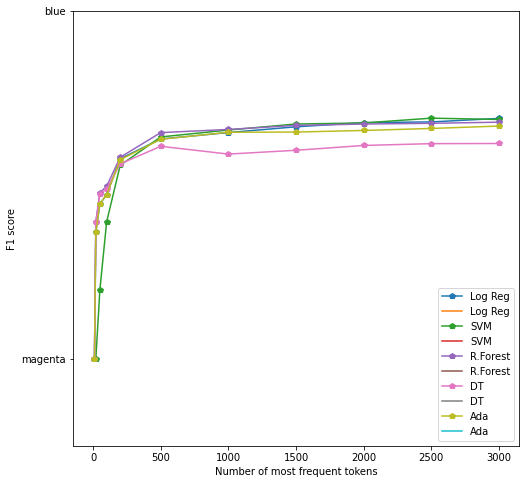

In [67]:
tokens = [10, 20, 50,100,200,500,1000,1500,2000,2500,3000] 

# import 
file = 'Data/data.csv'
dataframe = pd.read_csv(file, error_bad_lines=False, sep=";")
df = dataframe[:500]

strategy_evaluation(df,tokens)